### EDA Predictions (Joint)

In [1]:
# set the path to enable relative imports
import os
from pathlib import Path
curr_path = Path(os.getcwd()).parent
os.chdir(curr_path)

In [2]:
import joblib
from main.active_learning.datasets import ALDataset
import torch
import pandas as pd
from main.active_learning.utils import tokenize_sentences
from main.active_learning.utils import seed_pool_split
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd
import numpy as np
from main.active_learning.datasets import ALDataset
from main.active_learning.utils import seed_pool_split, init_dataloader
from main.joint_disjoint.utils import train_joint, train_disjoint, test_joint, test_disjoint
from main.active_learning.utils import tokenize_sentences, set_device
import matplotlib.pyplot as plt

C:\Users\basti\Anaconda3\envs\ai_thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import BertForSequenceClassification, BertTokenizer

In [4]:
model = BertForSequenceClassification.from_pretrained(
             'bert-base-uncased',
             num_labels=2,
             output_attentions=False,
             output_hidden_states=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [5]:
model.load_state_dict(torch.load('models/va_model_state.pt'))

<All keys matched successfully>

In [10]:
# prep some data for prediction

sample_200 = pd.read_csv('files/datasets/labeled/l01_reuters_sample200.csv')
sample_800 = pd.read_csv('files/datasets/labeled/l02_reuters_sample800.csv')

sent_df = pd.concat([sample_200, sample_800])

sent_df = sent_df[sent_df['is_miscellaneous'] == False]

# extract sentences and valence/arousal labels as numpy arrays
sentences = sent_df.sentence.values
v_labels = sent_df.valence.values
a_labels = sent_df.arousal.values
va_labels = np.vstack((v_labels, a_labels)).T


# handle tokenization of sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = 70
input_ids, attention_masks = tokenize_sentences(tokenizer, sentences, MAX_LEN)

# convert label arrays into tensors
v_labels = torch.tensor(v_labels)
a_labels = torch.tensor(a_labels)
va_labels = torch.tensor(va_labels)

# define experiment parameters
RANDOM_STATE = 42
TRAIN_SIZE = 967
BATCH_SIZE = 16
EPOCHS = 4
LR = 1e-5

# seperate 75% training set, 25% test set
va_train_ds, _ = seed_pool_split(input_ids, attention_masks, va_labels,
                                          seed_size=TRAIN_SIZE, random_state=RANDOM_STATE)


# initialize AL Dataset for training and testing data
va_train_ds_al = ALDataset(va_train_ds[0], va_train_ds[1], va_train_ds[2])
#va_test_ds_al = ALDataset(va_test_ds[0], va_test_ds[1], va_test_ds[2])

# initialize dataloaders
va_train_dl = init_dataloader(va_train_ds_al, BATCH_SIZE, type='sequential')
#va_test_dl = init_dataloader(va_test_ds_al, BATCH_SIZE, type='random')

In [11]:
len(va_train_dl.dataset)

967

In [12]:
sent_df

,Unnamed: 0,sentence,id,article_id,valence,arousal,is_annotated,is_miscellaneous,rank_value,is_drafted,rank_idx,draft_time
0,0.0,The automaker also said it is considering intr...,186,43,0.64,0.51,True,False,0.01,NaN,NaN,NaN
1,1.0,It fell 12 percent last year.,274,63,0.39,0.49,True,False,0.66,NaN,NaN,NaN
2,2.0,Dozens of companies in the sector merged in th...,2540,615,0.50,0.70,True,False,0.87,NaN,NaN,NaN
3,3.0,Annual revenues for the government IT business...,3313,782,0.36,0.54,True,False,0.67,NaN,NaN,NaN
4,4.0,The Swedish crown rose versus the dollar and e...,4024,936,0.55,0.39,True,False,0.34,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
795,NaN,OTHER BIDDERS A Pfizer move on As...,109689,16753,0.58,0.64,True,False,NaN,True,504.0,2022-08-25T09:40:51.0593080
796,NaN,"The driver of a 2003 CTS, in a co...",109823,16770,0.32,0.55,True,False,NaN,True,263.0,2022-06-23T09:57:25.3611610
797,NaN,Barra also met with accident victims' familie...,110083,16907,0.39,0.58,True,False,NaN,True,372.0,2022-08-25T09:26:12.3074480
798,NaN,The additional 14 deaths occurred after the 13...,110089,16907,0.23,0.69,True,False,NaN,True,416.0,2022-07-19T16:17:36.8375170


In [13]:
# predict ALL the values

v_allpreds = []
a_allpreds = []

device = set_device()
model.eval()  # set model to evaluation mode
with torch.no_grad():
    for X, _, y in va_train_dl:
        X, y = X.to(device), y.to(device)
        out = model(X)
        pred = out.logits
        print(pred)
        # seperate valence and arousal errors
        valence_pred, arousal_pred = pred.detach().numpy()[:, 0], pred.detach().numpy()[:, 1]
        v_allpreds.extend(list(valence_pred))
        a_allpreds.extend(list(arousal_pred))
        
        print('Valence: ', valence_pred)
        print('Arousal: ', arousal_pred)
        

Using device: cpu
tensor([[0.4870, 0.5317],
        [0.4928, 0.5280],
        [0.4945, 0.5297],
        [0.4872, 0.5309],
        [0.4929, 0.5274],
        [0.5044, 0.5148],
        [0.4916, 0.5308],
        [0.4936, 0.5160],
        [0.4920, 0.5191],
        [0.4994, 0.5249],
        [0.4948, 0.5242],
        [0.5083, 0.5253],
        [0.5061, 0.5149],
        [0.5091, 0.5176],
        [0.4676, 0.5077],
        [0.4963, 0.5196]])
Valence:  [0.48703986 0.49282598 0.494533   0.4872126  0.492887   0.504362
 0.49162903 0.49357268 0.4920115  0.49942684 0.49475914 0.50828135
 0.5061109  0.50914586 0.4676215  0.49633133]
Arousal:  [0.5317442  0.5280084  0.5297216  0.5309384  0.52743113 0.514801
 0.5307842  0.5159879  0.51910853 0.5248972  0.52416044 0.5252661
 0.5148955  0.5176264  0.50768757 0.5196233 ]
tensor([[0.5002, 0.5270],
        [0.4845, 0.5179],
        [0.4657, 0.5261],
        [0.4661, 0.5338],
        [0.5102, 0.5123],
        [0.4956, 0.5265],
        [0.4891, 0.5196],
        

tensor([[0.5055, 0.5203],
        [0.4777, 0.5181],
        [0.4682, 0.5338],
        [0.5037, 0.5233],
        [0.4996, 0.5269],
        [0.4709, 0.4965],
        [0.4971, 0.5375],
        [0.4950, 0.5277],
        [0.4787, 0.5152],
        [0.4993, 0.5191],
        [0.5050, 0.5097],
        [0.4793, 0.5259],
        [0.4834, 0.5180],
        [0.5079, 0.5164],
        [0.4723, 0.5320],
        [0.5111, 0.5168]])
Valence:  [0.505471   0.47773445 0.46815228 0.50367653 0.49959195 0.47094107
 0.49713033 0.49500626 0.47866246 0.49927825 0.50500387 0.47925985
 0.4833783  0.50793326 0.4722545  0.51114607]
Arousal:  [0.5202991  0.5180771  0.5337758  0.5233459  0.52692664 0.49651012
 0.5374706  0.5276835  0.51517326 0.51909524 0.50968444 0.5258811
 0.51803553 0.5163923  0.53202945 0.5167582 ]
tensor([[0.4843, 0.5297],
        [0.5149, 0.5159],
        [0.4860, 0.5267],
        [0.5046, 0.5130],
        [0.4958, 0.5326],
        [0.4999, 0.5274],
        [0.4957, 0.5207],
        [0.5070, 0.520

tensor([[0.4712, 0.5383],
        [0.4921, 0.5220],
        [0.4756, 0.5211],
        [0.4826, 0.5265],
        [0.4887, 0.5303],
        [0.5050, 0.5114],
        [0.4639, 0.5321],
        [0.4901, 0.5157],
        [0.4824, 0.5496],
        [0.4772, 0.5052],
        [0.5133, 0.5179],
        [0.5099, 0.5168],
        [0.4880, 0.5190],
        [0.4966, 0.5302],
        [0.4903, 0.5267],
        [0.4782, 0.5377]])
Valence:  [0.4711765  0.4920771  0.47557503 0.48264796 0.4886616  0.50504327
 0.46385008 0.49006423 0.4824421  0.4771947  0.5132824  0.50989485
 0.48798674 0.49660888 0.49034423 0.47821832]
Arousal:  [0.5383072  0.52199996 0.52106893 0.52647233 0.53030366 0.5114268
 0.53214955 0.51573664 0.5496415  0.505212   0.5178884  0.5168449
 0.5190385  0.53017336 0.52667034 0.5376514 ]
tensor([[0.5077, 0.5219],
        [0.4938, 0.5286],
        [0.5100, 0.5167],
        [0.5093, 0.5236],
        [0.4394, 0.5387],
        [0.4917, 0.5222],
        [0.4968, 0.5134],
        [0.4932, 0.5216

tensor([[0.4828, 0.5256],
        [0.4960, 0.5179],
        [0.5134, 0.5221],
        [0.4724, 0.5205],
        [0.5085, 0.5165],
        [0.4999, 0.5160],
        [0.4748, 0.5351],
        [0.5052, 0.5363],
        [0.5061, 0.5189],
        [0.5022, 0.5230],
        [0.5034, 0.5245],
        [0.5087, 0.5160],
        [0.4807, 0.5211],
        [0.4912, 0.5163],
        [0.4905, 0.5180],
        [0.4931, 0.5055]])
Valence:  [0.4828112  0.4960217  0.51337254 0.47243065 0.5084616  0.49991402
 0.47476545 0.50516254 0.5061184  0.5022325  0.50341344 0.5087437
 0.48070294 0.4912219  0.49047822 0.49310645]
Arousal:  [0.52559227 0.51788926 0.52211106 0.5204997  0.51650035 0.51600313
 0.5350796  0.53626686 0.518935   0.52301574 0.524459   0.51596534
 0.5210602  0.5162641  0.5179699  0.5055311 ]
tensor([[0.4922, 0.5196],
        [0.4845, 0.5059],
        [0.4957, 0.5283],
        [0.5014, 0.5318],
        [0.5129, 0.5151],
        [0.5051, 0.5186],
        [0.4901, 0.5233],
        [0.4966, 0.518

tensor([[0.4895, 0.5211],
        [0.4814, 0.5391],
        [0.4629, 0.5320],
        [0.4862, 0.5186],
        [0.4865, 0.5148],
        [0.5117, 0.5243],
        [0.4908, 0.5135],
        [0.4998, 0.5329],
        [0.4908, 0.5202],
        [0.4736, 0.5390],
        [0.4845, 0.5151],
        [0.4880, 0.5141],
        [0.4871, 0.5218],
        [0.4955, 0.5149],
        [0.4947, 0.5050],
        [0.4924, 0.5174]])
Valence:  [0.4895389  0.48144108 0.46290946 0.48622674 0.48646468 0.511688
 0.4908056  0.49984848 0.49081278 0.47364345 0.48449984 0.48795897
 0.4871161  0.49551535 0.49467182 0.492422  ]
Arousal:  [0.5210577  0.5391104  0.5319835  0.51856756 0.5148392  0.52427673
 0.51349473 0.5328881  0.5202418  0.5390105  0.5150995  0.5141332
 0.52179706 0.51486254 0.5050324  0.51739347]
tensor([[0.5003, 0.5297],
        [0.5082, 0.5152],
        [0.4952, 0.5188],
        [0.4887, 0.5250],
        [0.5056, 0.5197],
        [0.4904, 0.5238],
        [0.4981, 0.5264],
        [0.4957, 0.5352]

tensor([[0.4928, 0.5277],
        [0.5020, 0.5122],
        [0.4775, 0.5217],
        [0.5084, 0.5152],
        [0.5006, 0.5200],
        [0.4825, 0.5214],
        [0.4689, 0.5590],
        [0.4864, 0.5186],
        [0.4897, 0.5118],
        [0.5088, 0.5237],
        [0.4457, 0.6144],
        [0.5072, 0.5112],
        [0.4859, 0.5174],
        [0.4964, 0.5181],
        [0.4789, 0.5219],
        [0.5138, 0.5163]])
Valence:  [0.4927994  0.5019903  0.47749126 0.5084139  0.50062454 0.4825209
 0.4688694  0.48639187 0.48965168 0.5088356  0.44573456 0.50724316
 0.4859269  0.4963953  0.4788901  0.5138001 ]
Arousal:  [0.52768624 0.51222384 0.52171963 0.51521045 0.52004504 0.52142316
 0.5590003  0.5185985  0.5117715  0.52369577 0.6143625  0.51121825
 0.5173875  0.5181314  0.5218673  0.5162547 ]
tensor([[0.4998, 0.5217],
        [0.4980, 0.5115],
        [0.5081, 0.5227],
        [0.5012, 0.5188],
        [0.4934, 0.5210],
        [0.5025, 0.5223],
        [0.5111, 0.5153],
        [0.4607, 0.526

In [15]:
sent_df

,Unnamed: 0,sentence,id,article_id,valence,arousal,is_annotated,is_miscellaneous,rank_value,is_drafted,rank_idx,draft_time
0,0.0,The automaker also said it is considering intr...,186,43,0.64,0.51,True,False,0.01,NaN,NaN,NaN
1,1.0,It fell 12 percent last year.,274,63,0.39,0.49,True,False,0.66,NaN,NaN,NaN
2,2.0,Dozens of companies in the sector merged in th...,2540,615,0.50,0.70,True,False,0.87,NaN,NaN,NaN
3,3.0,Annual revenues for the government IT business...,3313,782,0.36,0.54,True,False,0.67,NaN,NaN,NaN
4,4.0,The Swedish crown rose versus the dollar and e...,4024,936,0.55,0.39,True,False,0.34,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
795,NaN,OTHER BIDDERS A Pfizer move on As...,109689,16753,0.58,0.64,True,False,NaN,True,504.0,2022-08-25T09:40:51.0593080
796,NaN,"The driver of a 2003 CTS, in a co...",109823,16770,0.32,0.55,True,False,NaN,True,263.0,2022-06-23T09:57:25.3611610
797,NaN,Barra also met with accident victims' familie...,110083,16907,0.39,0.58,True,False,NaN,True,372.0,2022-08-25T09:26:12.3074480
798,NaN,The additional 14 deaths occurred after the 13...,110089,16907,0.23,0.69,True,False,NaN,True,416.0,2022-07-19T16:17:36.8375170


In [17]:
sent_df.iloc[0, 1]

'The automaker also said it is considering introducing subcompact SUV models in South Korea, the United States and Europe.'

In [20]:
# map back sentence > predictions

sentence_preds = pd.DataFrame(columns=['sentence', 'sentence_id', 'valence', 'arousal'])


for i, (v_pred, a_pred) in enumerate(zip(v_allpreds, a_allpreds)):
    
    sentence = sent_df.iloc[i, 1]
    sentence_id = sent_df.iloc[i, 2]

    sentence_preds.loc[i]  = [sentence,
                                 sentence_id,
                                  v_pred,
                                  a_pred]
    


In [21]:
sentence_preds

,sentence,sentence_id,valence,arousal
0,The automaker also said it is considering intr...,186,0.487040,0.531744
1,It fell 12 percent last year.,274,0.492826,0.528008
2,Dozens of companies in the sector merged in th...,2540,0.494533,0.529722
3,Annual revenues for the government IT business...,3313,0.487213,0.530938
4,The Swedish crown rose versus the dollar and e...,4024,0.492887,0.527431
...,...,...,...,...
962,"The offer, if successful, would bring together...",109632,0.487437,0.517929
963,OTHER BIDDERS A Pfizer move on As...,109689,0.479906,0.528073
964,"The driver of a 2003 CTS, in a co...",109823,0.473679,0.523292
965,Barra also met with accident victims' familie...,110083,0.489238,0.534465


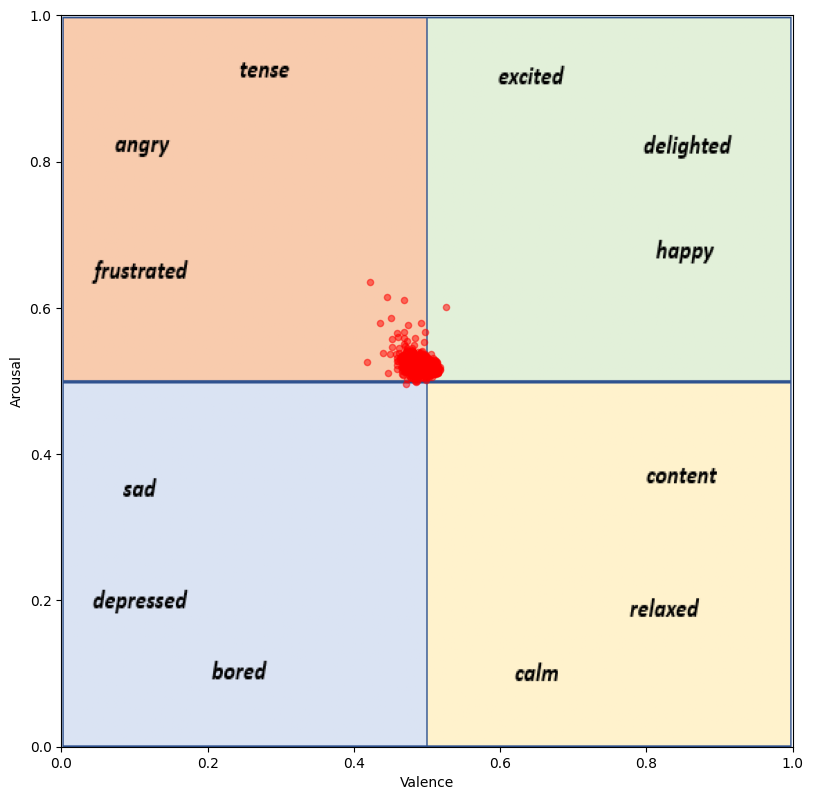

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 9.5)
img = plt.imread('files/images/circumplex_model_3.png')

im=ax.imshow(img, extent=[0, 1, 0, 1], zorder=1)
ax.scatter(v_allpreds, a_allpreds, c='r', zorder=2, s= 20, alpha=0.5)
ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
plt.savefig('files/results/overlayed_scatters/preds_joint_os.png')

In [28]:
# pick out example sentences

sentence_preds[sentence_preds['sentence_id'].isin([104848, 67722, 41109, 35951, 5719])]



,sentence,sentence_id,valence,arousal
11,Boeing plans to deliver the 737 MAX in the thi...,5719,0.508281,0.525266
68,"""Deutsche Bank has been plagued by fines and i...",35951,0.492778,0.528456
126,"In currencies, the dollar eased on the safe ha...",67722,0.508066,0.518507
482,Hedge fund industry sources said the plan sugg...,41109,0.504714,0.519664
930,Sky Italia and Sky Deutschland (DE:SKYDn).The ...,104848,0.472702,0.523860
